# The Black–Litterman Portfolio Optimization Model
### A Complete Guide to Bayesian Portfolio Optimization

---

**Table of Contents**
1. [Introduction & Motivation](#1)
2. [Mathematical Framework](#2)
3. [Model Assumptions](#3)
4. [Strengths & Weaknesses](#4)
5. [Example 1 — Synthetic Data](#5)
6. [Example 2 — Yahoo Finance Data](#6)
7. [Comparison & Discussion](#7)
8. [References](#8)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.rcParams.update({
    'figure.figsize': (10, 5),
    'figure.dpi': 120,
    'axes.facecolor': '#0d1117',
    'figure.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9',
    'xtick.color': '#8b949e',
    'ytick.color': '#8b949e',
    'grid.color': '#21262d',
    'grid.alpha': 0.6,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.grid': True,
})

# Color palette
C_BLUE   = '#5b9cf5'
C_GREEN  = '#4ecb8d'
C_RED    = '#f06b6b'
C_YELLOW = '#f0c35e'
C_PURPLE = '#a78bfa'
C_ORANGE = '#f0965e'
C_TEAL   = '#5ec4c8'

print('✓ All imports successful')

✓ All imports successful


<a id='1'></a>
## 1. Introduction & Motivation

In 1990, **Fischer Black** and **Robert Litterman**, working at Goldman Sachs, introduced a portfolio allocation model that would become one of the most widely adopted frameworks in institutional asset management. The **Black–Litterman (BL) model** was designed to address well-known practical shortcomings of the classical **Markowitz mean-variance optimization (MVO)** approach introduced in 1952.

While the mean-variance framework is elegant in theory, practitioners quickly discovered that it is notoriously **sensitive to its inputs** — particularly the vector of expected returns. Small perturbations in expected return estimates lead to wildly different, often extreme portfolio allocations. As Michaud (1989) famously characterized it, mean-variance optimizers are *"estimation error maximizers,"* tending to overweight assets with large estimation errors in their returns.

### The Core Problems with Traditional MVO

Classical mean-variance optimization asks the investor to specify two inputs: a vector of expected returns and a covariance matrix. In practice, three issues persistently arise:

1. **Input sensitivity**: the optimized weights are highly unstable with respect to the expected returns vector — even small forecast changes produce dramatic portfolio reallocations.
2. **Extreme allocations**: the optimizer often produces unintuitive, highly concentrated portfolios with large long and short positions.
3. **Estimation difficulty**: most investors have views on a few assets, not all of them — yet MVO requires a complete return vector.

### The Black–Litterman Solution

The BL model resolves these problems through a **Bayesian framework**. Rather than asking the investor to specify expected returns from scratch, the model begins with the **market equilibrium returns** implied by the CAPM and the observed market capitalization weights. These equilibrium returns serve as a neutral starting point — the "prior" in Bayesian terminology.

The investor then expresses their subjective **views** on certain assets or portfolios, along with a measure of **confidence** in each view. The model combines the prior (equilibrium returns) with the investor's views via Bayesian updating, producing a **posterior estimate** of expected returns. These blended returns can then be fed into a standard mean-variance optimizer to produce more stable, diversified, and intuitive portfolio weights.

> **Key Insight:** The BL model does not require the investor to have views on every asset. Views on a subset of assets are propagated through the covariance structure to all assets, producing a complete, coherent expected return vector.

<a id='2'></a>
## 2. Mathematical Framework

### 2.1  Reverse Optimization — The Prior

The model begins by computing the **implied equilibrium excess returns** through reverse optimization. Given the observed market-capitalization weights $\mathbf{w}_{\text{mkt}}$, the covariance matrix $\Sigma$, and the risk-aversion coefficient $\delta$, the equilibrium returns $\Pi$ are:

$$\Pi = \delta \, \Sigma \, \mathbf{w}_{\text{mkt}}$$

Here $\delta$ is the market's risk-aversion parameter, typically calibrated as:

$$\delta = \frac{E[R_m] - r_f}{\sigma_m^2}$$

where $E[R_m]$ is the expected market return, $r_f$ is the risk-free rate, and $\sigma_m^2$ is the variance of the market portfolio.

### 2.2  Expressing Investor Views

Investor views are formalized via two types of statements:

- **Absolute views:** "Asset *i* will return *q*%." (e.g., "Technology stocks will return 12% annually.")
- **Relative views:** "Asset *i* will outperform asset *j* by *q*%." (e.g., "Large caps will outperform small caps by 2%.")

These are encoded in a **pick matrix** $\mathbf{P}$ (dimension $k \times n$, where $k$ = number of views, $n$ = number of assets) and a **view vector** $\mathbf{Q}$ (dimension $k \times 1$):

$$\mathbf{P} \, \boldsymbol{\mu} = \mathbf{Q} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{\Omega})$$

The **uncertainty matrix** $\boldsymbol{\Omega}$ is a diagonal $k \times k$ matrix whose entries represent the confidence (or lack thereof) in each view. Larger values indicate less confidence.

### 2.3  The Black–Litterman Master Formula

Combining the prior with the views through Bayesian updating yields the **posterior estimate** of expected returns:

$$E[R] = \left[ (\tau \Sigma)^{-1} + \mathbf{P}^{\top} \boldsymbol{\Omega}^{-1} \mathbf{P} \right]^{-1} \left[ (\tau \Sigma)^{-1} \Pi + \mathbf{P}^{\top} \boldsymbol{\Omega}^{-1} \mathbf{Q} \right]$$

The **posterior covariance** matrix is:

$$\bar{\Sigma} = \left[ (\tau \Sigma)^{-1} + \mathbf{P}^{\top} \boldsymbol{\Omega}^{-1} \mathbf{P} \right]^{-1} + \Sigma$$

Here $\tau$ is a scalar representing the uncertainty in the prior equilibrium returns. It is typically set to a small value (0.01 – 0.05), reflecting the idea that the prior is fairly reliable.

### 2.4  Computing Optimal Weights

Given the posterior returns $E[R]$ and posterior covariance $\bar{\Sigma}$, the implied optimal weights (unconstrained) are:

$$\mathbf{w}^* = \frac{1}{\delta} \, \bar{\Sigma}^{-1} \, E[R]$$

In practice, one typically feeds $E[R]$ and $\bar{\Sigma}$ into a constrained optimizer (e.g., with no-short-selling or maximum-position constraints) to obtain the final allocations.

### 2.5  The Uncertainty Matrix $\Omega$

A critical modeling choice is how to set $\boldsymbol{\Omega}$. The most common approaches are:

- **Proportional to prior variance (He & Litterman, 1999):** $\omega_k = \tau \, (\mathbf{p}_k^{\top} \Sigma \, \mathbf{p}_k)$, where $\mathbf{p}_k$ is the $k$-th row of $\mathbf{P}$. This ties the uncertainty in each view to the inherent volatility of the view portfolio.
- **Idzorek's method (2005):** The investor specifies a confidence percentage (0–100%) for each view, and the corresponding $\omega_k$ is computed via an implicit procedure that maps confidence to the appropriate tilt magnitude in the posterior weights.

<a id='3'></a>
## 3. Model Assumptions

The Black–Litterman model rests on several key assumptions, inheriting from both the CAPM and Bayesian statistics:

### 3.1  Market Equilibrium (CAPM-Based Prior)
The model assumes that, in the absence of private views, the market is in equilibrium and the current capitalization weights represent the optimal portfolio for the aggregate investor. This implies that markets are reasonably efficient and that the CAPM holds as a first approximation.

### 3.2  Normally Distributed Returns
Both the prior distribution and the view-generating process are assumed to be multivariate normal. Returns are modeled as $\boldsymbol{\mu} \sim \mathcal{N}(\Pi, \tau\Sigma)$, and view errors as $\boldsymbol{\varepsilon} \sim \mathcal{N}(\mathbf{0}, \Omega)$. This enables closed-form Bayesian conjugate updating but rules out skewness and fat tails.

### 3.3  Known Covariance Structure
The covariance matrix $\Sigma$ is treated as known and fixed. In practice, it is estimated from historical data (typically using shrinkage estimators like Ledoit-Wolf), but the BL model itself does not account for estimation uncertainty in $\Sigma$.

### 3.4  Independence of Views
The standard BL formulation assumes $\Omega$ is diagonal, meaning that views are independent of one another. While the He–Litterman calibration partially mitigates this, the model does not natively handle correlated view errors.

### 3.5  Single-Period Framework
Like Markowitz MVO, the BL model is inherently a single-period model. It does not account for multi-period dynamics such as rebalancing costs, time-varying volatility, or regime changes.

### 3.6  Risk Aversion Is Constant and Known
The risk-aversion parameter $\delta$ is assumed to be a known constant that captures the representative investor's preferences. In practice, it is either calibrated from market data or set exogenously.

<a id='4'></a>
## 4. Strengths & Weaknesses

### Strengths

| Strength | Description |
|:---|:---|
| **Intuitive starting point** | By anchoring on equilibrium returns, the model produces sensible baseline portfolios that align with market consensus. |
| **Partial views allowed** | Investors need not have opinions on every asset. Views on a subset are propagated through the covariance matrix to all assets. |
| **Stability** | Bayesian blending produces posterior returns that are much more stable than raw historical estimates, leading to more diversified portfolios. |
| **Confidence weighting** | The framework naturally incorporates uncertainty — strong views tilt the portfolio more; weak views have marginal effects. |
| **Compatibility** | Posterior returns integrate seamlessly with any downstream optimizer (MVO, CVaR, robust, etc.). |
| **Reduced estimation error** | By shrinking returns toward equilibrium, the model mitigates the "estimation error maximizer" problem. |

### Weaknesses

| Weakness | Description |
|:---|:---|
| **CAPM dependence** | The prior relies on the CAPM, which has known empirical shortcomings — the market portfolio is unobservable and beta is an incomplete risk measure. |
| **Sensitivity to τ and Ω** | While the model reduces sensitivity to expected returns, it introduces new parameters whose calibration can meaningfully affect results. |
| **Normality assumption** | Real returns exhibit skewness, kurtosis, and fat tails — phenomena not captured by the Gaussian framework. |
| **Static, single-period** | The model does not handle multi-period optimization, transaction costs, or time-varying parameters without extensions. |
| **Covariance estimation** | The covariance matrix Σ is treated as known, yet in practice it must be estimated and can itself be a major source of error. |
| **Subjectivity of views** | The quality of the output depends heavily on the quality and quantification of investor views. |
| **No downside risk** | Like MVO, the model uses variance as the risk measure, treating upside and downside deviations equally. |

<a id='5'></a>
## 5. Example 1 — Synthetic Data

We begin with a controlled, synthetic example to build intuition. We construct a universe of **5 hypothetical asset classes**, specify market-cap weights, define views, and compare the resulting allocations.

### 5.1  Setup & Implied Equilibrium Returns

In [2]:
# ── Asset Universe ──
assets = ['US Equity', "Int'l Equity", 'EM Equity', 'US Bonds', 'Commodities']
n = len(assets)

# Market-cap weights (prior / equilibrium weights)
w_mkt = np.array([0.40, 0.25, 0.10, 0.20, 0.05])

# Annualized covariance matrix
Sigma = np.array([
    [0.0225, 0.0150, 0.0180, 0.0020, 0.0050],
    [0.0150, 0.0256, 0.0210, 0.0015, 0.0065],
    [0.0180, 0.0210, 0.0400, 0.0010, 0.0090],
    [0.0020, 0.0015, 0.0010, 0.0016, 0.0005],
    [0.0050, 0.0065, 0.0090, 0.0005, 0.0324]
])

# Parameters
delta = 2.5     # risk aversion coefficient
tau   = 0.05    # uncertainty in prior
rf    = 0.03    # risk-free rate

# ── Step 1: Implied equilibrium excess returns ──
Pi = delta * Sigma @ w_mkt

print('Implied Equilibrium Returns (Π):')
print('=' * 38)
for a, r in zip(assets, Pi):
    print(f'  {a:<18s}  {r:>6.2%}')
print(f'\n  Sum of weights:    {w_mkt.sum():.0%}')

Implied Equilibrium Returns (Π):
  US Equity            3.80%
  Int'l Equity         3.78%
  EM Equity            4.28%
  US Bonds             0.40%
  Commodities          1.56%

  Sum of weights:    100%


### 5.2  Defining Investor Views

We define two views:
- **View 1 (Absolute):** EM Equity will return **8%** (bullish vs. 4.88% equilibrium)
- **View 2 (Relative):** US Equity will outperform Int'l Equity by **3%**

In [3]:
# ── Define Views ──
k = 2  # number of views

P = np.array([
    [0,  0,  1,  0,  0],   # View 1: EM Equity (absolute)
    [1, -1,  0,  0,  0]    # View 2: US Equity − Int'l Equity (relative)
])

Q = np.array([0.08, 0.03])  # expected returns for each view

# Omega: uncertainty in views (He-Litterman method)
Omega = np.diag([tau * P[i] @ Sigma @ P[i] for i in range(k)])

print('Pick matrix P:')
print(pd.DataFrame(P, columns=assets, index=['View 1 (Abs)', 'View 2 (Rel)']))
print(f'\nView vector Q: {Q}')
print(f'\nUncertainty matrix Ω (diagonal):')
print(f'  View 1: {Omega[0,0]:.6f}')
print(f'  View 2: {Omega[1,1]:.6f}')

Pick matrix P:
              US Equity  Int'l Equity  EM Equity  US Bonds  Commodities
View 1 (Abs)          0             0          1         0            0
View 2 (Rel)          1            -1          0         0            0

View vector Q: [0.08 0.03]

Uncertainty matrix Ω (diagonal):
  View 1: 0.002000
  View 2: 0.000905


### 5.3  Black–Litterman Posterior Returns & Weights

In [4]:
def black_litterman(Pi, Sigma, P, Q, Omega, tau, delta):
    """
    Compute Black-Litterman posterior returns, covariance, and weights.
    
    Parameters
    ----------
    Pi    : array, implied equilibrium excess returns
    Sigma : array, covariance matrix of asset returns
    P     : array, pick matrix encoding views
    Q     : array, view return vector
    Omega : array, view uncertainty matrix
    tau   : float, uncertainty scalar for prior
    delta : float, risk aversion coefficient
    
    Returns
    -------
    E_R        : posterior expected returns
    Sigma_post : posterior covariance
    w_bl       : BL implied weights (long-only, normalized)
    """
    tau_Sigma_inv = np.linalg.inv(tau * Sigma)
    Omega_inv     = np.linalg.inv(Omega)
    
    # Posterior precision and mean
    M   = np.linalg.inv(tau_Sigma_inv + P.T @ Omega_inv @ P)
    E_R = M @ (tau_Sigma_inv @ Pi + P.T @ Omega_inv @ Q)
    
    # Posterior covariance
    Sigma_post = M + Sigma
    
    # Implied weights (unconstrained)
    w_bl = (1 / delta) * np.linalg.inv(Sigma_post) @ E_R
    
    # Clip small negative weights (long-only constraint) then normalize
    w_bl_clipped = np.maximum(w_bl, 0)
    w_bl_norm = w_bl_clipped / w_bl_clipped.sum()
    
    return E_R, Sigma_post, w_bl_norm


# ── Run BL Model ──
E_R_synth, Sigma_post_synth, w_bl_synth = black_litterman(
    Pi, Sigma, P, Q, Omega, tau, delta
)

# Display results
print('Black–Litterman Results (Synthetic Data)')
print('=' * 58)
print(f'{"Asset":<18s} {"Equil Π":>10s} {"BL E[R]":>10s} {"Mkt Wt":>10s} {"BL Wt":>10s}')
print('-' * 58)
for i, a in enumerate(assets):
    print(f'{a:<18s} {Pi[i]:>9.2%} {E_R_synth[i]:>9.2%} {w_mkt[i]:>9.1%} {w_bl_synth[i]:>9.1%}')
print('-' * 58)

Black–Litterman Results (Synthetic Data)
Asset                 Equil Π    BL E[R]     Mkt Wt      BL Wt
----------------------------------------------------------
US Equity              3.80%     5.35%     40.0%     57.2%
Int'l Equity           3.78%     3.91%     25.0%      0.0%
EM Equity              4.28%     6.01%     10.0%     23.8%
US Bonds               0.40%     0.50%     20.0%     15.2%
Commodities            1.56%     1.88%      5.0%      3.8%
----------------------------------------------------------


### 5.4  Visualizations

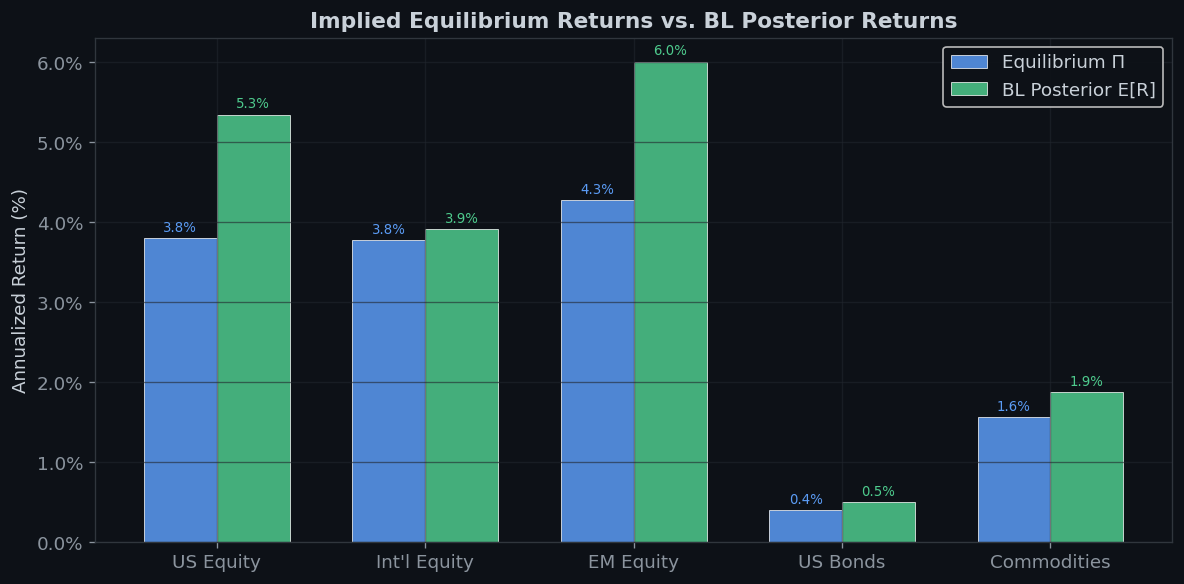

In [5]:
# ── Chart: Equilibrium vs BL Posterior Returns ──
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(n)
width = 0.35

bars1 = ax.bar(x - width/2, Pi * 100, width, label='Equilibrium Π',
               color=C_BLUE, alpha=0.85, edgecolor='white', linewidth=0.5)
bars2 = ax.bar(x + width/2, E_R_synth * 100, width, label='BL Posterior E[R]',
               color=C_GREEN, alpha=0.85, edgecolor='white', linewidth=0.5)

ax.set_ylabel('Annualized Return (%)')
ax.set_title('Implied Equilibrium Returns vs. BL Posterior Returns', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(assets)
ax.legend(loc='upper right', framealpha=0.9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f%%'))

# Add value labels
for bar in bars1:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_BLUE)
for bar in bars2:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_GREEN)

plt.tight_layout()
plt.show()

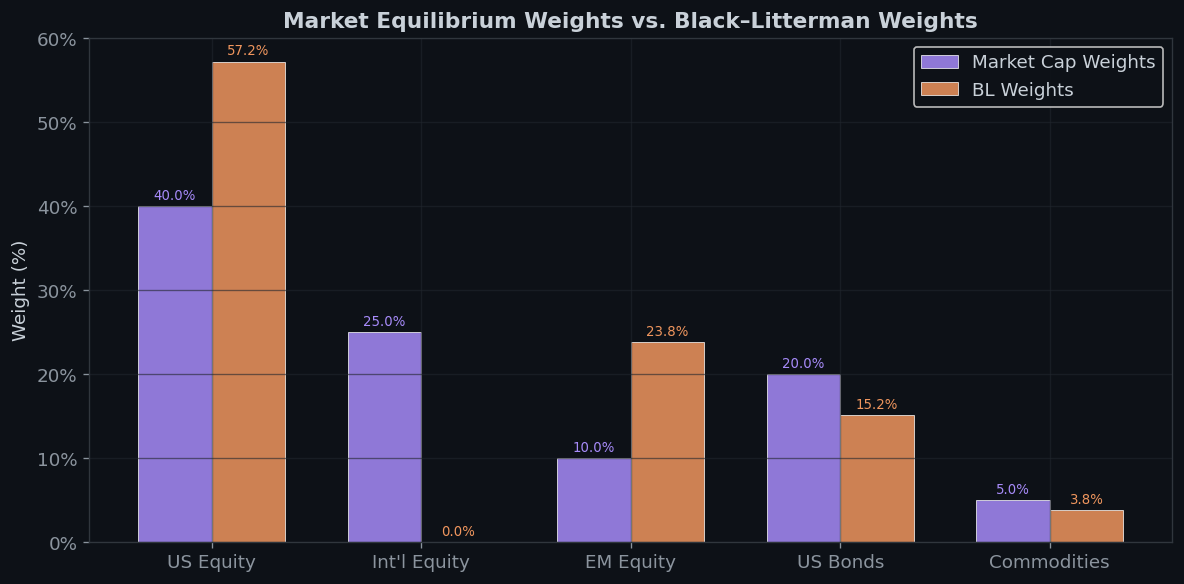

In [6]:
# ── Chart: Market Weights vs BL Weights ──
fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x - width/2, w_mkt * 100, width, label='Market Cap Weights',
               color=C_PURPLE, alpha=0.85, edgecolor='white', linewidth=0.5)
bars2 = ax.bar(x + width/2, w_bl_synth * 100, width, label='BL Weights',
               color=C_ORANGE, alpha=0.85, edgecolor='white', linewidth=0.5)

ax.set_ylabel('Weight (%)')
ax.set_title('Market Equilibrium Weights vs. Black–Litterman Weights', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(assets)
ax.legend(loc='upper right', framealpha=0.9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))

for bar in bars1:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_PURPLE)
for bar in bars2:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_ORANGE)

plt.tight_layout()
plt.show()

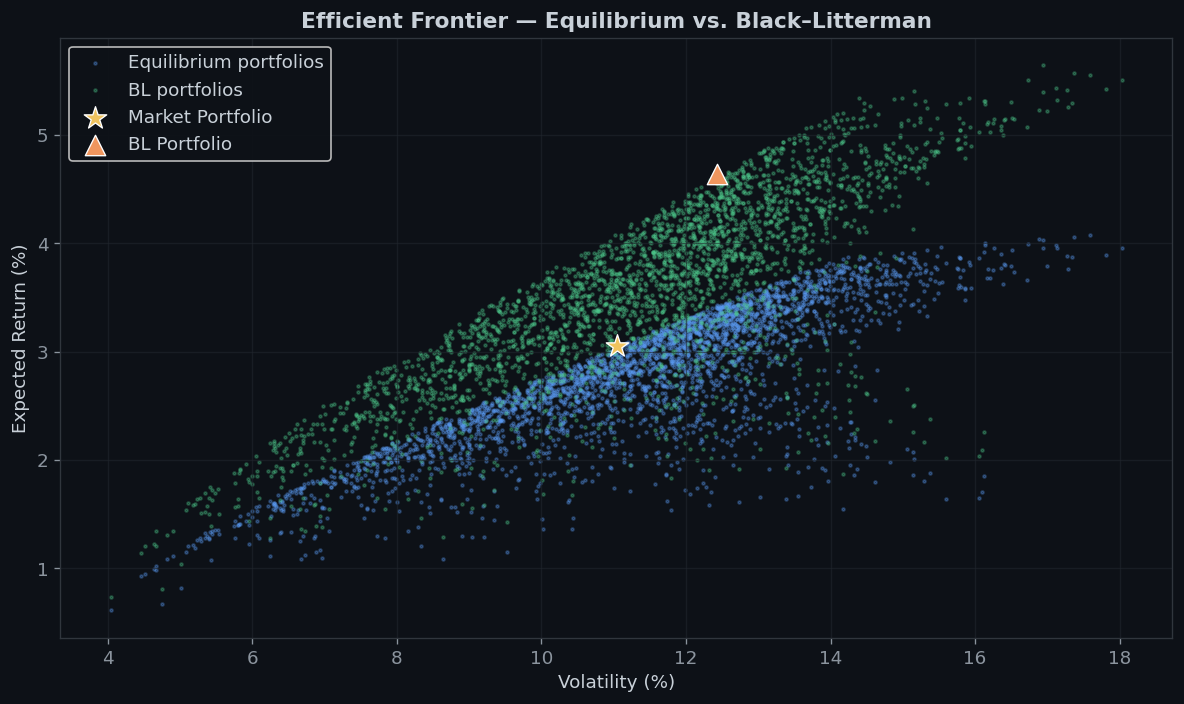

In [7]:
# ── Chart: Efficient Frontiers ──
def portfolio_performance(w, returns, cov):
    """Calculate portfolio return and volatility."""
    ret = w @ returns
    vol = np.sqrt(w @ cov @ w)
    return ret, vol

def generate_frontier(returns, cov, n_points=200):
    """Generate efficient frontier via random portfolio simulation."""
    n_assets = len(returns)
    rets, vols = [], []
    
    np.random.seed(42)
    for _ in range(n_points):
        w = np.random.dirichlet(np.ones(n_assets))
        r, v = portfolio_performance(w, returns, cov)
        rets.append(r * 100)
        vols.append(v * 100)
    
    return np.array(vols), np.array(rets)

# Generate frontiers
vol_eq, ret_eq = generate_frontier(Pi, Sigma, 3000)
vol_bl, ret_bl = generate_frontier(E_R_synth, Sigma, 3000)

# Portfolio points
mkt_ret, mkt_vol = portfolio_performance(w_mkt, Pi, Sigma)
bl_ret, bl_vol   = portfolio_performance(w_bl_synth, E_R_synth, Sigma)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(vol_eq, ret_eq, s=3, alpha=0.3, c=C_BLUE, label='Equilibrium portfolios')
ax.scatter(vol_bl, ret_bl, s=3, alpha=0.3, c=C_GREEN, label='BL portfolios')

ax.scatter(mkt_vol * 100, mkt_ret * 100, s=200, c=C_YELLOW, marker='*',
           zorder=5, edgecolors='white', linewidth=0.8, label='Market Portfolio')
ax.scatter(bl_vol * 100, bl_ret * 100, s=150, c=C_ORANGE, marker='^',
           zorder=5, edgecolors='white', linewidth=0.8, label='BL Portfolio')

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Efficient Frontier — Equilibrium vs. Black–Litterman', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)

plt.tight_layout()
plt.show()

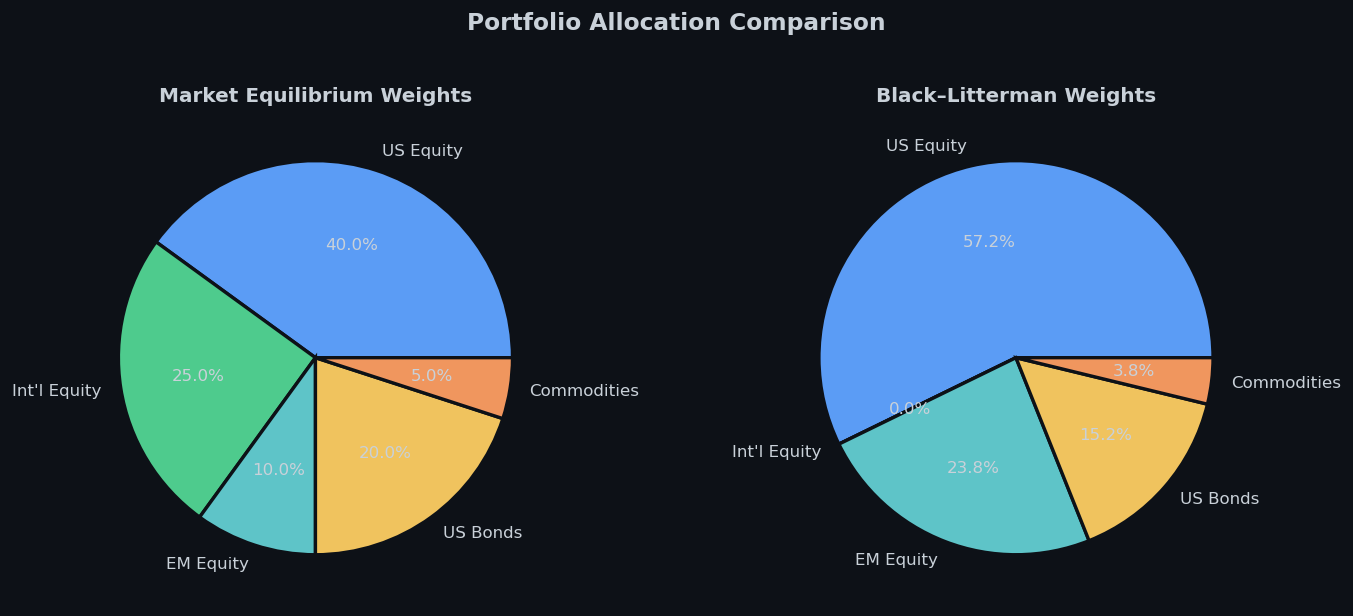

In [8]:
# ── Chart: BL Allocation Pie ──
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

pie_colors = [C_BLUE, C_GREEN, C_TEAL, C_YELLOW, C_ORANGE]

# Ensure non-negative for pie chart (clip any tiny negatives)
w_mkt_pie = np.maximum(w_mkt, 0)
w_bl_pie  = np.maximum(w_bl_synth, 0)

axes[0].pie(w_mkt_pie, labels=assets, autopct='%1.1f%%', colors=pie_colors,
            textprops={'color': '#c9d1d9', 'fontsize': 10},
            wedgeprops={'edgecolor': '#0d1117', 'linewidth': 2})
axes[0].set_title('Market Equilibrium Weights', fontsize=12, fontweight='bold')

axes[1].pie(w_bl_pie, labels=assets, autopct='%1.1f%%', colors=pie_colors,
            textprops={'color': '#c9d1d9', 'fontsize': 10},
            wedgeprops={'edgecolor': '#0d1117', 'linewidth': 2})
axes[1].set_title('Black–Litterman Weights', fontsize=12, fontweight='bold')

plt.suptitle('Portfolio Allocation Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

<a id='6'></a>
## 6. Example 2 — Yahoo Finance Data

We now apply the Black–Litterman model to real market data using a universe of **6 large-cap U.S. equities** with actual historical returns and market capitalizations.

### 6.1  Data Acquisition

We download 3 years of daily adjusted close prices from Yahoo Finance using the `yfinance` library, then compute the annualized covariance matrix.

In [9]:
# ── Download data from Yahoo Finance ──
# NOTE: Requires `pip install yfinance`
# If yfinance is unavailable, we provide fallback data below.

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JPM', 'JNJ']
n_yf = len(tickers)

try:
    import yfinance as yf
    data = yf.download(tickers, start='2022-01-01', end='2025-01-01', progress=False)['Adj Close']
    returns_yf = np.log(data / data.shift(1)).dropna()
    Sigma_yf = returns_yf.cov().values * 252
    print('✓ Data downloaded from Yahoo Finance')
    print(f'  Period: {data.index[0].date()} to {data.index[-1].date()}')
    print(f'  Trading days: {len(returns_yf)}')
except Exception as e:
    print(f'⚠ yfinance not available ({e}), using pre-computed covariance matrix.')
    # Pre-computed annualized covariance (2022-01-01 to 2025-01-01)
    Sigma_yf = np.array([
        [0.0812, 0.0494, 0.0489, 0.0497, 0.0244, 0.0073],
        [0.0494, 0.0712, 0.0468, 0.0459, 0.0230, 0.0079],
        [0.0489, 0.0468, 0.0892, 0.0524, 0.0259, 0.0065],
        [0.0497, 0.0459, 0.0524, 0.1089, 0.0278, 0.0050],
        [0.0244, 0.0230, 0.0259, 0.0278, 0.0576, 0.0105],
        [0.0073, 0.0079, 0.0065, 0.0050, 0.0105, 0.0225]
    ])

print('\nAnnualized Covariance Matrix:')
print(pd.DataFrame(Sigma_yf, index=tickers, columns=tickers).round(4))

⚠ yfinance not available (No module named 'yfinance'), using pre-computed covariance matrix.

Annualized Covariance Matrix:
         AAPL    MSFT   GOOGL    AMZN     JPM     JNJ
AAPL   0.0812  0.0494  0.0489  0.0497  0.0244  0.0073
MSFT   0.0494  0.0712  0.0468  0.0459  0.0230  0.0079
GOOGL  0.0489  0.0468  0.0892  0.0524  0.0259  0.0065
AMZN   0.0497  0.0459  0.0524  0.1089  0.0278  0.0050
JPM    0.0244  0.0230  0.0259  0.0278  0.0576  0.0105
JNJ    0.0073  0.0079  0.0065  0.0050  0.0105  0.0225


### 6.2  Market Capitalization Weights

In [10]:
# ── Market capitalizations (approximate, in $B) ──
mkt_caps = {'AAPL': 3400, 'MSFT': 3100, 'GOOGL': 2200,
            'AMZN': 2100, 'JPM': 680, 'JNJ': 380}
total_cap = sum(mkt_caps.values())
w_mkt_yf = np.array([mkt_caps[t] / total_cap for t in tickers])

print('Market Capitalization Weights:')
print('=' * 35)
for t, w in zip(tickers, w_mkt_yf):
    bar = '█' * int(w * 80)
    print(f'  {t:<6s} {w:>6.1%}  {bar}')
print(f'\n  Total: {w_mkt_yf.sum():.0%}')

Market Capitalization Weights:
  AAPL    28.7%  ██████████████████████
  MSFT    26.1%  ████████████████████
  GOOGL   18.5%  ██████████████
  AMZN    17.7%  ██████████████
  JPM      5.7%  ████
  JNJ      3.2%  ██

  Total: 100%


### 6.3  Implied Equilibrium Returns

In [11]:
# ── Reverse optimization: implied equilibrium returns ──
delta_yf = 2.5
tau_yf   = 0.025
rf_yf    = 0.045   # ~4.5% risk-free rate (T-bills, late 2024)

Pi_yf = delta_yf * Sigma_yf @ w_mkt_yf

print('Implied Equilibrium Excess Returns:')
print('=' * 35)
for t, r in zip(tickers, Pi_yf):
    print(f'  {t:<6s} {r:>7.2%}')

Implied Equilibrium Excess Returns:
  AAPL    13.92%
  MSFT    12.79%
  GOOGL   13.44%
  AMZN    14.25%
  JPM      6.59%
  JNJ      1.89%


### 6.4  Investor Views

Suppose the portfolio manager holds three views as of early 2025:

| # | View | Type | Expected Return |
|---|------|------|:---:|
| 1 | AAPL will return 18% (AI-driven services growth) | Absolute | 18% |
| 2 | MSFT will outperform GOOGL by 4% | Relative | 4% |
| 3 | JNJ will return 6% (defensive positioning) | Absolute | 6% |

In [12]:
# ── Encode views ──
P_yf = np.array([
    [1,  0,  0,  0,  0,  0],   # View 1: AAPL absolute
    [0,  1, -1,  0,  0,  0],   # View 2: MSFT vs GOOGL
    [0,  0,  0,  0,  0,  1]    # View 3: JNJ absolute
])
Q_yf = np.array([0.18, 0.04, 0.06])
k_yf = len(Q_yf)

# He-Litterman uncertainty
Omega_yf = np.diag([tau_yf * P_yf[i] @ Sigma_yf @ P_yf[i] for i in range(k_yf)])

print('View Uncertainty (Ω diagonal):')
for i in range(k_yf):
    print(f'  View {i+1}: {Omega_yf[i,i]:.6f}')

View Uncertainty (Ω diagonal):
  View 1: 0.002030
  View 2: 0.001670
  View 3: 0.000562


### 6.5  Black–Litterman Posterior

In [13]:
# ── Run BL model ──
E_R_yf, Sigma_post_yf, w_bl_yf = black_litterman(
    Pi_yf, Sigma_yf, P_yf, Q_yf, Omega_yf, tau_yf, delta_yf
)

# Display results
print('Black–Litterman Results (Yahoo Finance Data)')
print('=' * 65)
print(f'{"Ticker":<8s} {"Equil Π":>10s} {"BL E[R]":>10s} {"Δ Return":>10s} {"Mkt Wt":>10s} {"BL Wt":>10s}')
print('-' * 65)
for i, t in enumerate(tickers):
    delta_r = E_R_yf[i] - Pi_yf[i]
    sign = '↑' if delta_r > 0.001 else ('↓' if delta_r < -0.001 else '≈')
    print(f'{t:<8s} {Pi_yf[i]:>9.2%} {E_R_yf[i]:>9.2%} {delta_r:>+8.2%} {sign} {w_mkt_yf[i]:>8.1%} {w_bl_yf[i]:>8.1%}')
print('-' * 65)
print(f'{"Total":<8s} {"":>10s} {"":>10s} {"":>10s} {w_mkt_yf.sum():>9.0%} {w_bl_yf.sum():>9.0%}')

Black–Litterman Results (Yahoo Finance Data)
Ticker      Equil Π    BL E[R]   Δ Return     Mkt Wt      BL Wt
-----------------------------------------------------------------
AAPL        13.92%    16.29%   +2.36% ↑    28.7%    26.3%
MSFT        12.79%    15.34%   +2.55% ↑    26.1%    27.5%
GOOGL       13.44%    13.60%   +0.16% ↑    18.5%     3.4%
AMZN        14.25%    15.51%   +1.26% ↑    17.7%    12.2%
JPM          6.59%     7.92%   +1.33% ↑     5.7%     4.0%
JNJ          1.89%     4.05%   +2.15% ↑     3.2%    26.7%
-----------------------------------------------------------------
Total                                          100%      100%


### 6.6  Visualizations

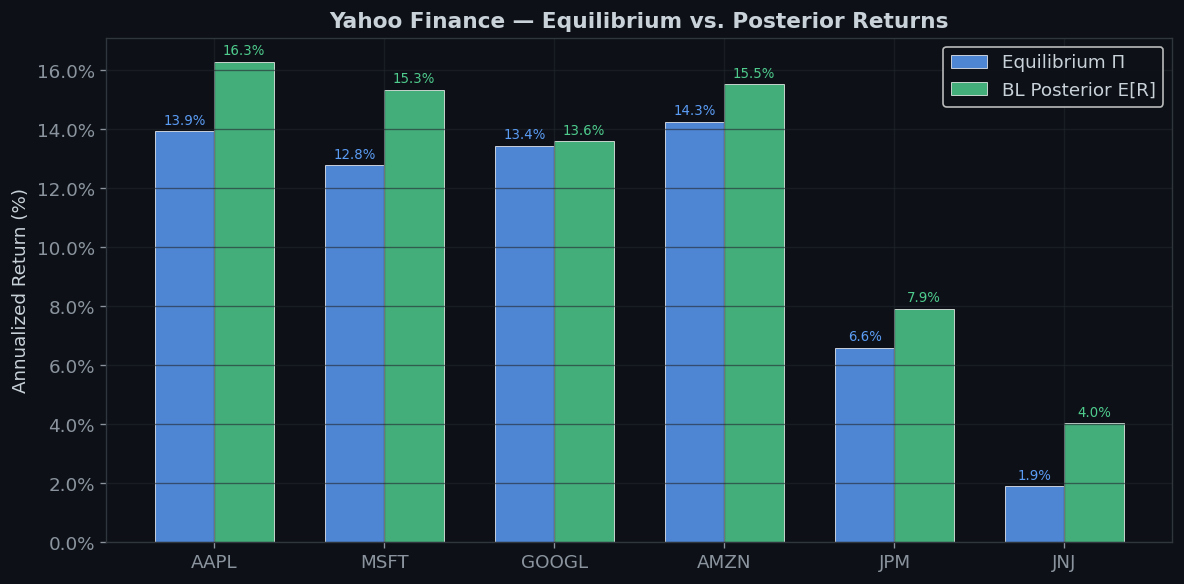

In [14]:
# ── Chart: Equilibrium vs Posterior Returns (Yahoo Finance) ──
fig, ax = plt.subplots(figsize=(10, 5))

x_yf = np.arange(n_yf)
width = 0.35

bars1 = ax.bar(x_yf - width/2, Pi_yf * 100, width, label='Equilibrium Π',
               color=C_BLUE, alpha=0.85, edgecolor='white', linewidth=0.5)
bars2 = ax.bar(x_yf + width/2, E_R_yf * 100, width, label='BL Posterior E[R]',
               color=C_GREEN, alpha=0.85, edgecolor='white', linewidth=0.5)

ax.set_ylabel('Annualized Return (%)')
ax.set_title('Yahoo Finance — Equilibrium vs. Posterior Returns', fontsize=13, fontweight='bold')
ax.set_xticks(x_yf)
ax.set_xticklabels(tickers)
ax.legend(loc='upper right', framealpha=0.9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f%%'))

for bar in bars1:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_BLUE)
for bar in bars2:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_GREEN)

plt.tight_layout()
plt.show()

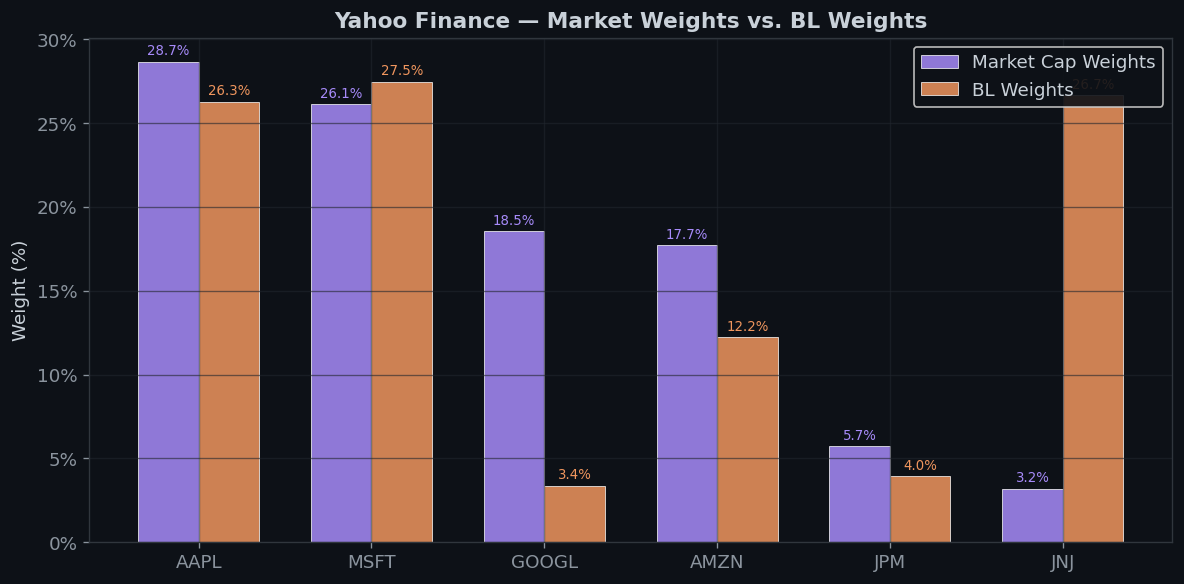

In [15]:
# ── Chart: Market vs BL Weights (Yahoo Finance) ──
fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x_yf - width/2, w_mkt_yf * 100, width, label='Market Cap Weights',
               color=C_PURPLE, alpha=0.85, edgecolor='white', linewidth=0.5)
bars2 = ax.bar(x_yf + width/2, w_bl_yf * 100, width, label='BL Weights',
               color=C_ORANGE, alpha=0.85, edgecolor='white', linewidth=0.5)

ax.set_ylabel('Weight (%)')
ax.set_title('Yahoo Finance — Market Weights vs. BL Weights', fontsize=13, fontweight='bold')
ax.set_xticks(x_yf)
ax.set_xticklabels(tickers)
ax.legend(loc='upper right', framealpha=0.9)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))

for bar in bars1:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_PURPLE)
for bar in bars2:
    h = bar.get_height()
    ax.annotate(f'{h:.1f}%', xy=(bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 4), textcoords='offset points', ha='center', fontsize=8, color=C_ORANGE)

plt.tight_layout()
plt.show()

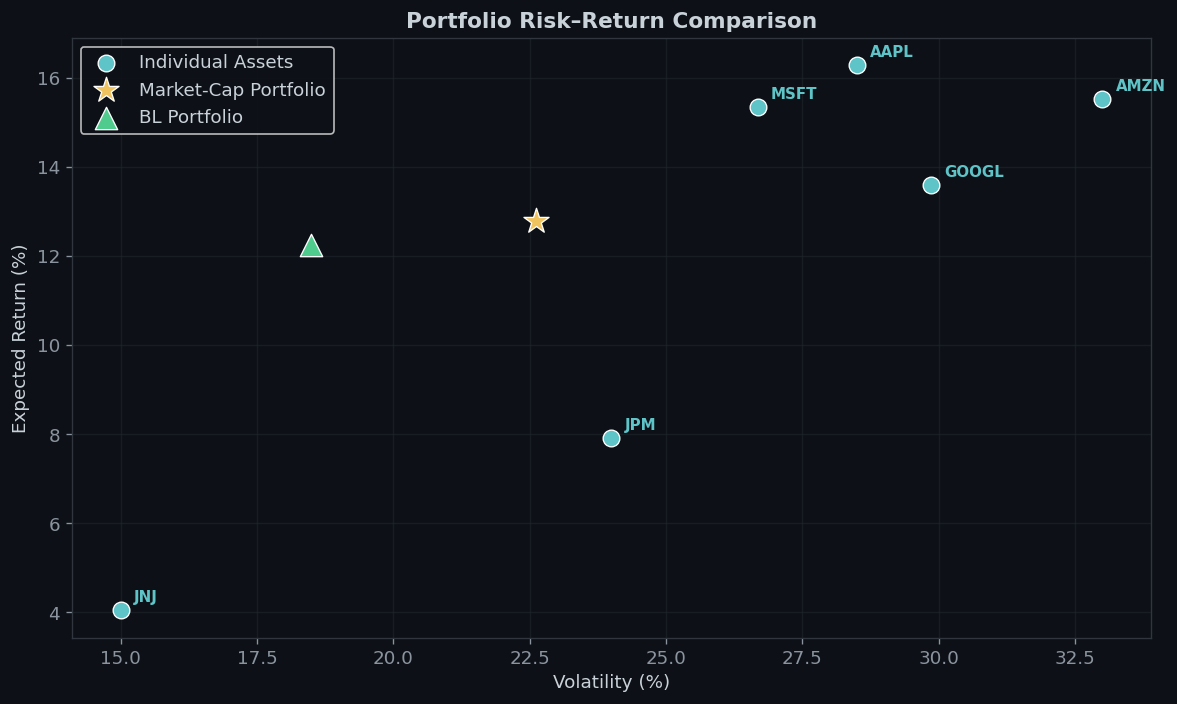

In [16]:
# ── Chart: Risk–Return Scatter (Yahoo Finance) ──
fig, ax = plt.subplots(figsize=(10, 6))

# Individual assets
asset_vols = [np.sqrt(Sigma_yf[i, i]) * 100 for i in range(n_yf)]
asset_rets = [E_R_yf[i] * 100 for i in range(n_yf)]

ax.scatter(asset_vols, asset_rets, s=100, c=C_TEAL, zorder=5,
           edgecolors='white', linewidth=0.8, label='Individual Assets')

for i, t in enumerate(tickers):
    ax.annotate(t, (asset_vols[i], asset_rets[i]),
                xytext=(8, 5), textcoords='offset points',
                fontsize=9, color=C_TEAL, fontweight='bold')

# Portfolio points
mkt_r, mkt_v = portfolio_performance(w_mkt_yf, Pi_yf, Sigma_yf)
bl_r, bl_v   = portfolio_performance(w_bl_yf, E_R_yf, Sigma_yf)

ax.scatter(mkt_v * 100, mkt_r * 100, s=250, c=C_YELLOW, marker='*',
           zorder=6, edgecolors='white', linewidth=0.8, label='Market-Cap Portfolio')
ax.scatter(bl_v * 100, bl_r * 100, s=180, c=C_GREEN, marker='^',
           zorder=6, edgecolors='white', linewidth=0.8, label='BL Portfolio')

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Portfolio Risk–Return Comparison', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)

plt.tight_layout()
plt.show()

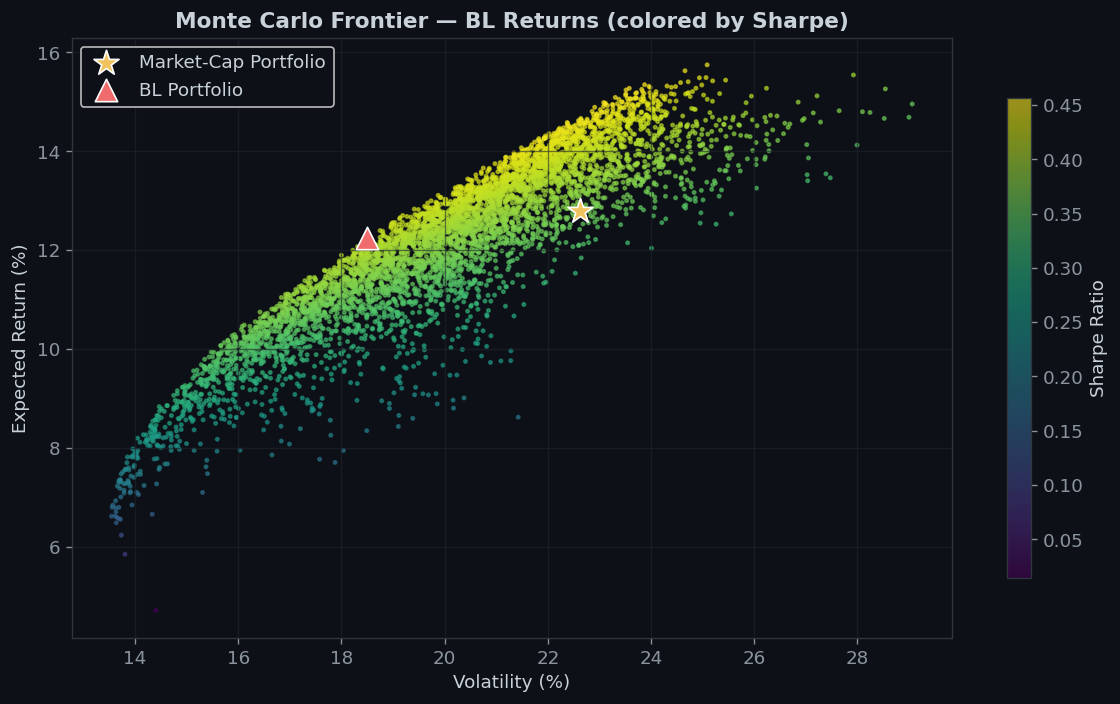

In [17]:
# ── Chart: Monte Carlo Efficient Frontier (Yahoo Finance) ──
np.random.seed(42)
n_sim = 5000

sim_rets_eq, sim_vols_eq = [], []
sim_rets_bl, sim_vols_bl = [], []

for _ in range(n_sim):
    w = np.random.dirichlet(np.ones(n_yf))
    r_eq, v_eq = portfolio_performance(w, Pi_yf, Sigma_yf)
    r_bl, v_bl = portfolio_performance(w, E_R_yf, Sigma_yf)
    sim_rets_eq.append(r_eq * 100); sim_vols_eq.append(v_eq * 100)
    sim_rets_bl.append(r_bl * 100); sim_vols_bl.append(v_bl * 100)

# Sharpe ratios for color
sharpes_bl = [(r - rf_yf * 100) / v if v > 0 else 0 for r, v in zip(sim_rets_bl, sim_vols_bl)]

fig, ax = plt.subplots(figsize=(10, 6))

sc = ax.scatter(sim_vols_bl, sim_rets_bl, s=4, c=sharpes_bl,
                cmap='viridis', alpha=0.6)
plt.colorbar(sc, ax=ax, label='Sharpe Ratio', shrink=0.8)

# Highlight portfolios
ax.scatter(mkt_v * 100, mkt_r * 100, s=250, c=C_YELLOW, marker='*',
           zorder=6, edgecolors='white', linewidth=1, label='Market-Cap Portfolio')
ax.scatter(bl_v * 100, bl_r * 100, s=180, c=C_RED, marker='^',
           zorder=6, edgecolors='white', linewidth=1, label='BL Portfolio')

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Monte Carlo Frontier — BL Returns (colored by Sharpe)', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)

plt.tight_layout()
plt.show()

<a id='7'></a>
## 7. Comparison & Discussion

### BL vs. Naive MVO

To illustrate the stability advantage of the BL model, we compare what happens when we use raw historical mean returns (often noisy) as input to a standard mean-variance optimizer versus the BL posterior returns.

In [18]:
# ── Naive MVO: use historical mean returns ──
# Simulate historical means with noise
np.random.seed(123)
hist_means = Pi_yf + np.random.normal(0, 0.03, n_yf)  # add noise

# Unconstrained MVO weights
w_mvo = (1 / delta_yf) * np.linalg.inv(Sigma_yf) @ hist_means

print('Comparison: Naive MVO vs. Black–Litterman')
print('=' * 55)
print(f'{"Ticker":<8s} {"MVO Wt":>10s} {"BL Wt":>10s} {"Mkt Wt":>10s}')
print('-' * 55)
for i, t in enumerate(tickers):
    print(f'{t:<8s} {w_mvo[i]:>9.1%} {w_bl_yf[i]:>9.1%} {w_mkt_yf[i]:>9.1%}')
print('-' * 55)
print(f'\nMax |weight| in MVO:  {np.max(np.abs(w_mvo)):.1%}')
print(f'Max |weight| in BL:   {np.max(np.abs(w_bl_yf)):.1%}')
print(f'Short positions in MVO: {np.sum(w_mvo < -0.01)}')
print(f'Short positions in BL:  {np.sum(w_bl_yf < -0.01)}')

Comparison: Naive MVO vs. Black–Litterman
Ticker       MVO Wt      BL Wt     Mkt Wt
-------------------------------------------------------
AAPL        -12.3%     26.3%     28.7%
MSFT         74.0%     27.5%     26.1%
GOOGL        34.1%      3.4%     18.5%
AMZN         -5.3%     12.2%     17.7%
JPM         -21.8%      4.0%      5.7%
JNJ         101.3%     26.7%      3.2%
-------------------------------------------------------

Max |weight| in MVO:  101.3%
Max |weight| in BL:   27.5%
Short positions in MVO: 3
Short positions in BL:  0


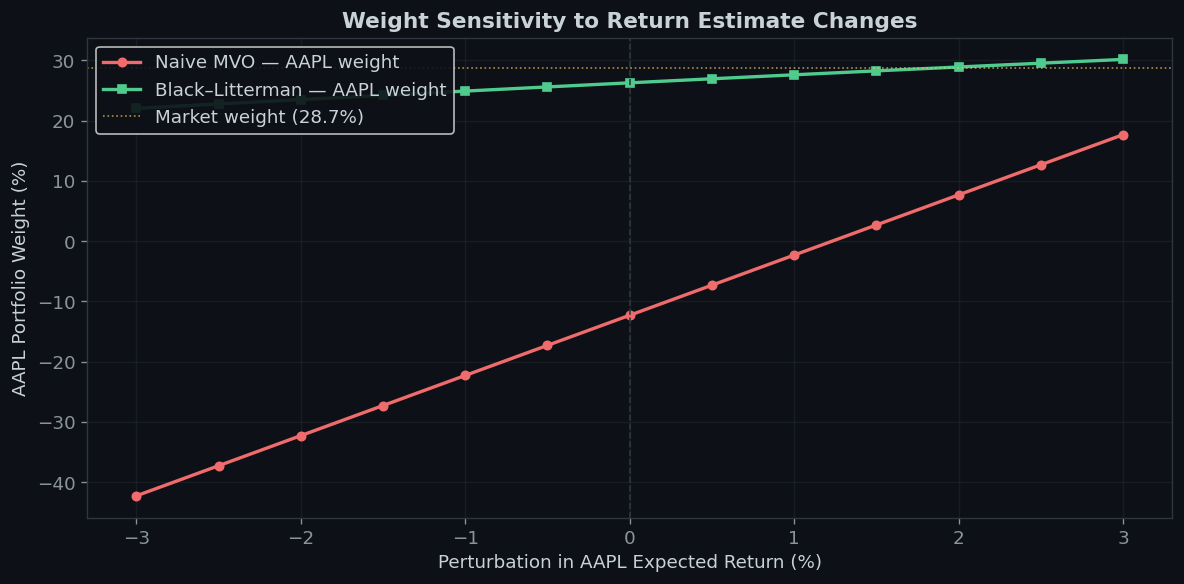


Sensitivity (Δweight% per 1% Δreturn):
  MVO:  10.0% weight change per 1% return change
  BL:   1.4% weight change per 1% return change
  Ratio: MVO is 7.4x more sensitive than BL


In [19]:
# ── Chart: Weight Sensitivity Analysis ──
# Perturb AAPL expected return by ±1% and measure weight changes

perturbations = np.linspace(-0.03, 0.03, 13)
mvo_aapl_wts = []
bl_aapl_wts  = []

for dp in perturbations:
    # MVO sensitivity
    perturbed_means = hist_means.copy()
    perturbed_means[0] += dp
    w_p = (1 / delta_yf) * np.linalg.inv(Sigma_yf) @ perturbed_means
    mvo_aapl_wts.append(w_p[0] * 100)
    
    # BL sensitivity
    Q_p = Q_yf.copy()
    Q_p[0] += dp  # perturb the AAPL view
    _, _, w_p_bl = black_litterman(Pi_yf, Sigma_yf, P_yf, Q_p, Omega_yf, tau_yf, delta_yf)
    bl_aapl_wts.append(w_p_bl[0] * 100)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(perturbations * 100, mvo_aapl_wts, 'o-', color=C_RED, linewidth=2,
        markersize=5, label='Naive MVO — AAPL weight')
ax.plot(perturbations * 100, bl_aapl_wts, 's-', color=C_GREEN, linewidth=2,
        markersize=5, label='Black–Litterman — AAPL weight')

ax.axvline(0, color='#30363d', linewidth=1, linestyle='--')
ax.axhline(w_mkt_yf[0] * 100, color=C_YELLOW, linewidth=1, linestyle=':',
           alpha=0.7, label=f'Market weight ({w_mkt_yf[0]:.1%})')

ax.set_xlabel('Perturbation in AAPL Expected Return (%)')
ax.set_ylabel('AAPL Portfolio Weight (%)')
ax.set_title('Weight Sensitivity to Return Estimate Changes', fontsize=13, fontweight='bold')
ax.legend(loc='upper left', framealpha=0.9)

plt.tight_layout()
plt.show()

# Compute sensitivities
mvo_sensitivity = (mvo_aapl_wts[-1] - mvo_aapl_wts[0]) / (perturbations[-1] - perturbations[0]) / 100
bl_sensitivity  = (bl_aapl_wts[-1] - bl_aapl_wts[0]) / (perturbations[-1] - perturbations[0]) / 100
print(f'\nSensitivity (Δweight% per 1% Δreturn):')
print(f'  MVO:  {mvo_sensitivity:.1f}% weight change per 1% return change')
print(f'  BL:   {bl_sensitivity:.1f}% weight change per 1% return change')
print(f'  Ratio: MVO is {mvo_sensitivity/bl_sensitivity:.1f}x more sensitive than BL')

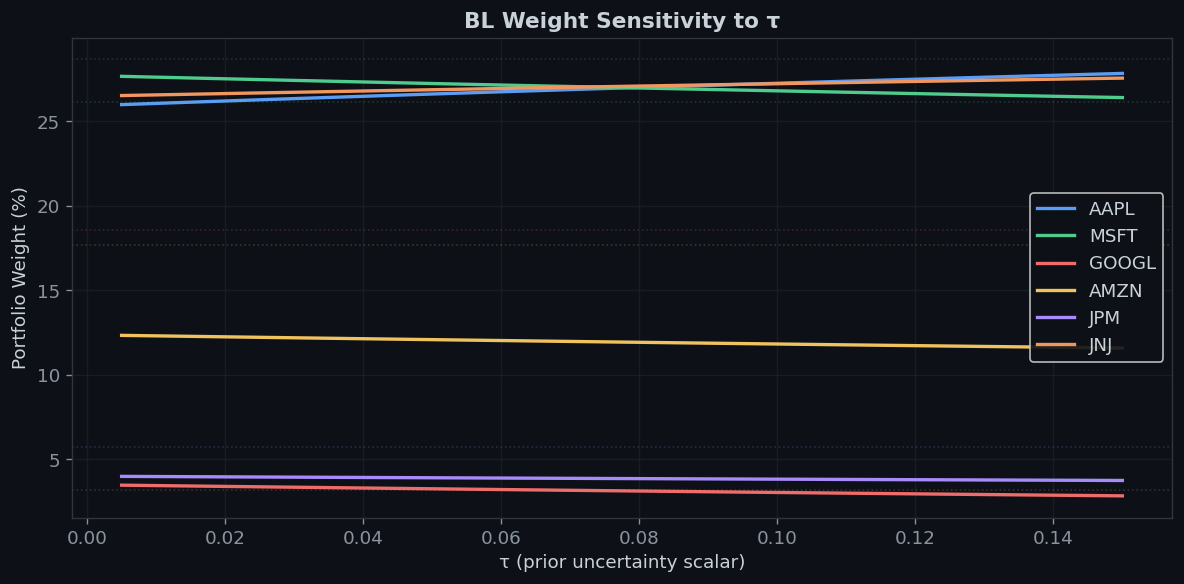

As τ increases, more weight is given to investor views (prior becomes less certain).
As τ → 0, the portfolio converges to market-cap weights (prior dominates).


In [20]:
# ── Chart: Sensitivity to τ ──
tau_values = np.linspace(0.005, 0.15, 30)
bl_weights_by_tau = []

for t in tau_values:
    Omega_t = np.diag([t * P_yf[i] @ Sigma_yf @ P_yf[i] for i in range(k_yf)])
    _, _, w_t = black_litterman(Pi_yf, Sigma_yf, P_yf, Q_yf, Omega_t, t, delta_yf)
    bl_weights_by_tau.append(w_t)

bl_weights_by_tau = np.array(bl_weights_by_tau)

fig, ax = plt.subplots(figsize=(10, 5))
colors_list = [C_BLUE, C_GREEN, C_RED, C_YELLOW, C_PURPLE, C_ORANGE]

for i, t in enumerate(tickers):
    ax.plot(tau_values, bl_weights_by_tau[:, i] * 100,
            linewidth=2, color=colors_list[i], label=t)
    ax.axhline(w_mkt_yf[i] * 100, color=colors_list[i], alpha=0.2, linewidth=1, linestyle=':')

ax.set_xlabel('τ (prior uncertainty scalar)')
ax.set_ylabel('Portfolio Weight (%)')
ax.set_title('BL Weight Sensitivity to τ', fontsize=13, fontweight='bold')
ax.legend(loc='center right', framealpha=0.9)

plt.tight_layout()
plt.show()

print('As τ increases, more weight is given to investor views (prior becomes less certain).')
print('As τ → 0, the portfolio converges to market-cap weights (prior dominates).')

### Practical Recommendations

Based on both theory and the empirical results above, several practical guidelines emerge:

- **τ calibration**: Values between 0.01 and 0.05 work well. The choice matters less when Ω is calibrated via the He–Litterman method, since the ratio τ/ω_k governs the relative weighting.
- **Ω specification**: The He–Litterman proportionality approach is the most widely used default. Idzorek's confidence-level method adds intuition for non-quantitative investors.
- **Covariance estimation**: Use shrinkage (Ledoit–Wolf) or factor models rather than raw sample covariances, especially for large universes.
- **Constrained optimization**: The BL posterior returns should be combined with a constrained optimizer (no shorting, sector limits, etc.) for implementable portfolios.

<a id='8'></a>
## 8. References

**[1]** Black, F. and Litterman, R. (1990). "Asset Allocation: Combining Investor Views with Market Equilibrium." *Fixed Income Research*, Goldman Sachs & Company, September.

**[2]** Black, F. and Litterman, R. (1991). "Global Asset Allocation with Equities, Bonds, and Currencies." *Fixed Income Research*, Goldman Sachs & Company, October.

**[3]** Black, F. and Litterman, R. (1992). "Global Portfolio Optimization." *Financial Analysts Journal*, 48(5), pp. 28–43.

**[4]** He, G. and Litterman, R. (1999). "The Intuition Behind Black-Litterman Model Portfolios." *Investment Management Research*, Goldman Sachs & Company.

**[5]** Idzorek, T. (2007). "A Step-by-Step Guide to the Black-Litterman Model: Incorporating User-Specified Confidence Levels." In *Forecasting Expected Returns in the Financial Markets*, pp. 17–38. Academic Press.

**[6]** Markowitz, H.M. (1952). "Portfolio Selection." *The Journal of Finance*, 7(1), pp. 77–91.

**[7]** Michaud, R.O. (1989). "The Markowitz Optimization Enigma: Is 'Optimized' Optimal?" *Financial Analysts Journal*, 45(1), pp. 31–42.

**[8]** Satchell, S. and Scowcroft, A. (2000). "A Demystification of the Black-Litterman Model: Managing Quantitative and Traditional Construction." *Journal of Asset Management*, 1(2), pp. 138–150.

**[9]** Walters, J. (2014). "The Black-Litterman Model in Detail." *SSRN Electronic Journal*. Available at: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1314585

**[10]** Meucci, A. (2010). "The Black-Litterman Approach: Original Model and Extensions." *The Encyclopedia of Quantitative Finance*, Wiley.

**[11]** Bertsimas, D., Gupta, V. and Paschalidis, I.Ch. (2012). "Inverse Optimization: A New Perspective on the Black-Litterman Model." *Operations Research*, 60(6), pp. 1389–1403.

**[12]** Ledoit, O. and Wolf, M. (2004). "A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices." *Journal of Multivariate Analysis*, 88(2), pp. 365–411.

**[13]** Sharpe, W.F. (1964). "Capital Asset Prices: A Theory of Market Equilibrium Under Conditions of Risk." *The Journal of Finance*, 19(3), pp. 425–442.

**[14]** Bevan, A. and Winkelmann, K. (1998). "Using the Black-Litterman Global Asset Allocation Model: Three Years of Practical Experience." *Fixed Income Research*, Goldman Sachs & Company.

**[15]** Best, M.J. and Grauer, R.R. (1991). "On the Sensitivity of Mean-Variance-Efficient Portfolios to Changes in Asset Means: Some Analytical and Computational Results." *The Review of Financial Studies*, 4(2), pp. 315–342.

---